# Patent Topic Modeling with LDA

**Minimal, Correct Pipeline for GPU Patent Analysis**

This notebook implements clean topic modeling on patent data using:
- Title + Abstract combination (high signal content)
- Patent boilerplate removal 
- LDA topic modeling
- Document-topic distribution output

## Expected Results

Given your GPU patent dataset, topics should cluster around:
- Video compression / H04N
- GPU scheduling 
- Memory usage
- Interconnect fabric
- Cache / memory hierarchy
- Power control
- Compute cores / SM architecture

**Dataset**: `raw/sw_keyword_1000.csv` (1000 patents with Title, Abstract, CPC Classifications)

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pathlib import Path
import re

## Step 1 — Load and Combine Text

The title often carries highly discriminative technical signal (e.g., "interconnect fabric," "power gating controller," "neural network accelerator"), while the abstract carries procedural content.

In [2]:
# Load the patent dataset
df = pd.read_csv("../data/patents/v1_core_expansion/core/raw/sw_keyword_1000.csv")

print(f"Dataset loaded: {df.shape[0]} patents")
print(f"Columns available: {list(df.columns)}")

# Combine title + abstract for maximum signal
df["text"] = (
    df["Title"].fillna("") + ". " + df["Abstract"].fillna("")
)

# Convert to list for processing
docs = df["text"].astype(str).tolist()

print(f"\nCombined {len(docs)} documents")
print(f"Example combined text:\n{docs[0][:200]}...")

Dataset loaded: 1000 patents
Columns available: ['#', 'Jurisdiction', 'Kind', 'Display Key', 'Lens ID', 'Publication Date', 'Publication Year', 'Application Number', 'Application Date', 'Priority Numbers', 'Earliest Priority Date', 'Title', 'Abstract', 'Applicants', 'Inventors', 'Owners', 'URL', 'Document Type', 'Has Full Text', 'Cites Patent Count', 'Cited by Patent Count', 'Simple Family Size', 'Simple Family Members', 'Simple Family Member Jurisdictions', 'Extended Family Size', 'Extended Family Members', 'Extended Family Member Jurisdictions', 'Sequence Count', 'CPC Classifications', 'IPCR Classifications', 'US Classifications', 'NPL Citation Count', 'NPL Resolved Citation Count', 'NPL Resolved Lens ID(s)', 'NPL Resolved External ID(s)', 'NPL Citations', 'Legal Status']

Combined 1000 documents
Example combined text:
Video decoding implementations for a graphics processing unit. Video decoding innovations for multithreading implementations and graphics processor unit ("GPU") implem

## Step 2 — Remove Patent Boilerplate (Critical)

Without this, LDA collapses into generic "method apparatus system" topics.

In [26]:
# Patent-specific stopwords to remove boilerplate language
custom_stopwords = [
    # Patent boilerplate
    "method", "apparatus", "system", "device", "devices",
    "plurality", "configured", "embodiment", "embodiments",
    "thereof", "wherein", "said", "may", "can", "could",
    "include", "includes", "including", "comprise", "comprises",
    "using", "use", "used", "application", "invention",
    "present", "disclosed", "described", "provided",
    "according", "various", "one", "two", "first", "second",
    "particular", "specific", "certain", "example", "examples",
    "figure", "figures", "shown", "illustrated",

    # Generic GPU identity terms (remove to expose substructure)
    "gpu", "gpus",
    "graphics", "graphic",
    "graphics processing",
    "figure", "figures",
    "fig", "figs",
    "shown", "illustrated", "illustrates", "illustrating",
    "depicted", "depicts", "depicting",
    "displayed", "displaying",
    "diagram", "diagrams",
    "drawing", "drawings",
    "chart", "charts",
    "graph", "graphs",
    "schematic", "schematics",
    "block", "block diagram", "block diagrams",
    "flowchart", "flowcharts",
    "flow", "flow diagram", "flow diagrams",

    # Generic computing noise
    "based", "multiple", "parallel",
    "computing", "compute",
    "data", "information",
    "execution", "executing",
    "command", "commands",
    "program", "programs",
    "instruction", "instructions",
    "thread", "threads",
    "processor", "processors"
]

more_patent_stopwords = [
    # super-common patent/claim glue
    "methods", "systems",
    "technique", "techniques",
    "provide", "provides", "providing",
    "perform", "performs", "performing",
    "receive", "receives", "receiving",
    "associated", "based",
    "comprising", "having",
    "disclosure", "describes", "describe",
    "sets", "forth",

    # generic sectioning words (often dominate)
    "aspects", "aspect",
    "implementation", "implementations",
    "example", "examples",
    "various",

    # generic nouns that add little signal in patents
    "operations", "operation",
    "process", "processes", "processing",
    "module", "modules",
    "component", "components",
    "elements", "element",
    "structure", "structures",

    # often unhelpful “quantifier” words in patents
    "different", "number", "set", "sets",
    "low", "high",  # keep if you care about performance tiers; otherwise remove
]

custom_stopwords.extend(more_patent_stopwords)


print(f"Custom stopwords defined: {len(custom_stopwords)} terms")
print("Sample stopwords:", custom_stopwords[:10])

Custom stopwords defined: 147 terms
Sample stopwords: ['method', 'apparatus', 'system', 'device', 'devices', 'plurality', 'configured', 'embodiment', 'embodiments', 'thereof']


## Step 3 — Vectorize Text

In [27]:
# Create vectorizer with patent-specific preprocessing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Combine English stopwords with our custom patent stopwords
all_stopwords = list(ENGLISH_STOP_WORDS.union(set(custom_stopwords)))

vectorizer = CountVectorizer(
    stop_words=all_stopwords,          # Use combined stopword list
    max_df=0.8,                        # Remove words in >80% of documents
    min_df=10,                          # Remove words in <7 documents (increase to 10 if noisy)
    ngram_range=(1, 2),                # Use unigrams and bigrams
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z0-9_]{1,}\b",
    binary=True,
    max_features=12000
)

# Fit and transform the documents
X = vectorizer.fit_transform(docs)

print(f"Vocabulary size: {X.shape[1]} terms")
print(f"Document-term matrix shape: {X.shape}")
print(f"Sparsity: {(1 - X.nnz / (X.shape[0] * X.shape[1])):.1%}")
print(f"Total stopwords used: {len(all_stopwords)}")

Vocabulary size: 878 terms
Document-term matrix shape: (1000, 878)
Sparsity: 97.6%
Total stopwords used: 447


## Step 4 — Fit LDA Model

In [28]:
# Set number of topics (start with 10, adjust based on results)
n_topics = 14

# Fit LDA model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch",        # More stable than online for smaller datasets
    max_iter=100,                  # Increase if convergence issues
    doc_topic_prior=0.1,           # Alpha: lower = sparser topic distributions
    topic_word_prior=0.01          # Beta: lower = sparser topics
)

print("Fitting LDA model...")
lda.fit(X)

# Transform documents to get topic distributions
doc_topic_dist = lda.transform(X)

print(f"LDA fitted with {n_topics} topics")
print(f"Document-topic distribution shape: {doc_topic_dist.shape}")
print(f"Each row contains P(topic_i | document) for topics 0-{n_topics-1}")
print("Avg max topic weight:", doc_topic_dist.max(axis=1).mean())


# Check convergence
print(f"Final log-likelihood: {lda.score(X):.2f}")

Fitting LDA model...
LDA fitted with 14 topics
Document-topic distribution shape: (1000, 14)
Each row contains P(topic_i | document) for topics 0-13
Avg max topic weight: 0.6306309089189986
Final log-likelihood: -138285.97


## Step 5 — Attach Topic Distribution to DataFrame

In [37]:
# Add topic probabilities to the original dataframe
for i in range(n_topics):
    df[f"topic_{i}"] = doc_topic_dist[:, i]

# Save enhanced dataset with topic distributions
output_path = "../data/patents/v1_core_expansion/core/parsed/patents_with_topics.csv"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path, index=False)

print(f"Enhanced dataset saved to: {output_path}")
print(f"New columns added: topic_0 through topic_{n_topics-1}")

# Show sample of topic distributions
print("\nSample topic distributions:")
topic_cols = [f"topic_{i}" for i in range(n_topics)]
print(df[["Title"] + topic_cols].head(3))

Enhanced dataset saved to: ../data/patents/v1_core_expansion/core/parsed/patents_with_topics.csv
New columns added: topic_0 through topic_13

Sample topic distributions:
                                               Title   topic_0   topic_1  \
0  Video decoding implementations for a graphics ...  0.000831  0.000831   
1  Systems and methods for virtualizing graphics ...  0.002416  0.321872   
2                            Media Integration Layer  0.003186  0.003186   

    topic_2   topic_3   topic_4   topic_5   topic_6   topic_7   topic_8  \
0  0.000831  0.989202  0.000831  0.000831  0.000831  0.000831  0.000831   
1  0.002416  0.002416  0.649136  0.002416  0.002416  0.002416  0.002416   
2  0.003185  0.003185  0.003185  0.003186  0.003185  0.003185  0.958593   

    topic_9  topic_10  topic_11  topic_12  topic_13  
0  0.000831  0.000831  0.000831  0.000831  0.000831  
1  0.002416  0.002416  0.002416  0.002416  0.002416  
2  0.003185  0.003185  0.003185  0.003185  0.003185  


## Step 6 — Interpret Topics (Critical)

Understanding what each topic represents through its top words.

In [31]:
# Extract and display top words for each topic
import numpy as np
topic_share = doc_topic_dist.mean(axis=0)
print(np.round(topic_share, 3))
print("min/max share:", topic_share.min(), topic_share.max())

feature_names = vectorizer.get_feature_names_out()

print("=" * 60)
print("TOPIC INTERPRETATION")
print("=" * 60)

topic_summaries = {}

for topic_idx, topic in enumerate(lda.components_):
    # Get top 15 words for this topic
    top_word_indices = topic.argsort()[-15:][::-1]  # Sort descending
    top_words = [feature_names[i] for i in top_word_indices]
    top_weights = [topic[i] for i in top_word_indices]
    
    topic_summaries[topic_idx] = top_words
    
    print(f"\nTopic {topic_idx}:")
    print(", ".join(top_words))
    print(f"(Weights: {[f'{w:.3f}' for w in top_weights[:5]]})")

print("\n" + "=" * 60)
print("EXPECTED GPU PATENT TOPICS:")
print("- Video compression / H04N")
print("- GPU scheduling / parallel processing") 
print("- Memory usage / cache hierarchy")
print("- Interconnect fabric / bus architectures")
print("- Power control / thermal management")
print("- Compute cores / SIMD architecture")
print("=" * 60)

# Save topic summaries
import json
topics_output_path = "../data/patents/v1_core_expansion/core/parsed/topic_summaries.json"
with open(topics_output_path, 'w') as f:
    json.dump(topic_summaries, f, indent=2)
    
print(f"\nTopic summaries saved to: {topics_output_path}")

[0.049 0.085 0.056 0.023 0.089 0.139 0.052 0.043 0.1   0.093 0.053 0.082
 0.076 0.058]
min/max share: 0.023414965559139328 0.13902028663235502
TOPIC INTERPRETATION

Topic 0:
central, buffer, central unit, rendering, performed, hardware, unit cpu, accelerated, memory, cpu, runtime, web, performed unit, rendering unit, renders
(Weights: ['23.311', '22.997', '22.822', '20.097', '19.329'])

Topic 1:
display, image, rendering, render, computer, rendered, frames, input, frame, stream, determining, generated, video, output, images
(Weights: ['63.930', '56.847', '53.993', '39.392', '34.333'])

Topic 2:
memory, bandwidth, efficient, bandwidth memory, performance, task, memory bandwidth, controller, buffer, power, fixed, miss, cause, tasks, memory controller
(Weights: ['30.750', '22.763', '17.384', '17.374', '16.986'])

Topic 3:
availability, slices, adjustment, decoding, uses, picture, innovations, memory usage, reduction, neighbor, intra, areas, video decoding, fractional, prediction
(Weights:

In [39]:
# ============================================================
# TOPIC DEFINITIONS (MANUAL LABELS)
# ============================================================

# Topic 0  – CPU–GPU runtime / execution coupling
# Topic 1  – Display pipeline / frame generation
# Topic 2  – Memory bandwidth & controller efficiency
# Topic 3  – Video decoding / codec acceleration
# Topic 4  – Virtualization / VM resource management
# Topic 5  – Graphics shader & rendering pipeline
# Topic 6  – General-purpose shared memory / host interface
# Topic 7  – Mode control / subsystem switching
# Topic 8  – Kernel execution / programmable compute layer
# Topic 9  – Cache hierarchy / memory levels
# Topic 10 – Memory response / storage path optimization
# Topic 11 – Tiling / latency / CPU–GPU path optimization
# Topic 12 – Integrated memory management / address transfer
# Topic 13 – ML acceleration / vGPU switching


## Topic Evolution Over Time

Visualize how topic distributions change across publication years to identify patent trends and technology evolution in GPU hardware.

Filtering to 2005-2023: 978 patents (from 1000 total)


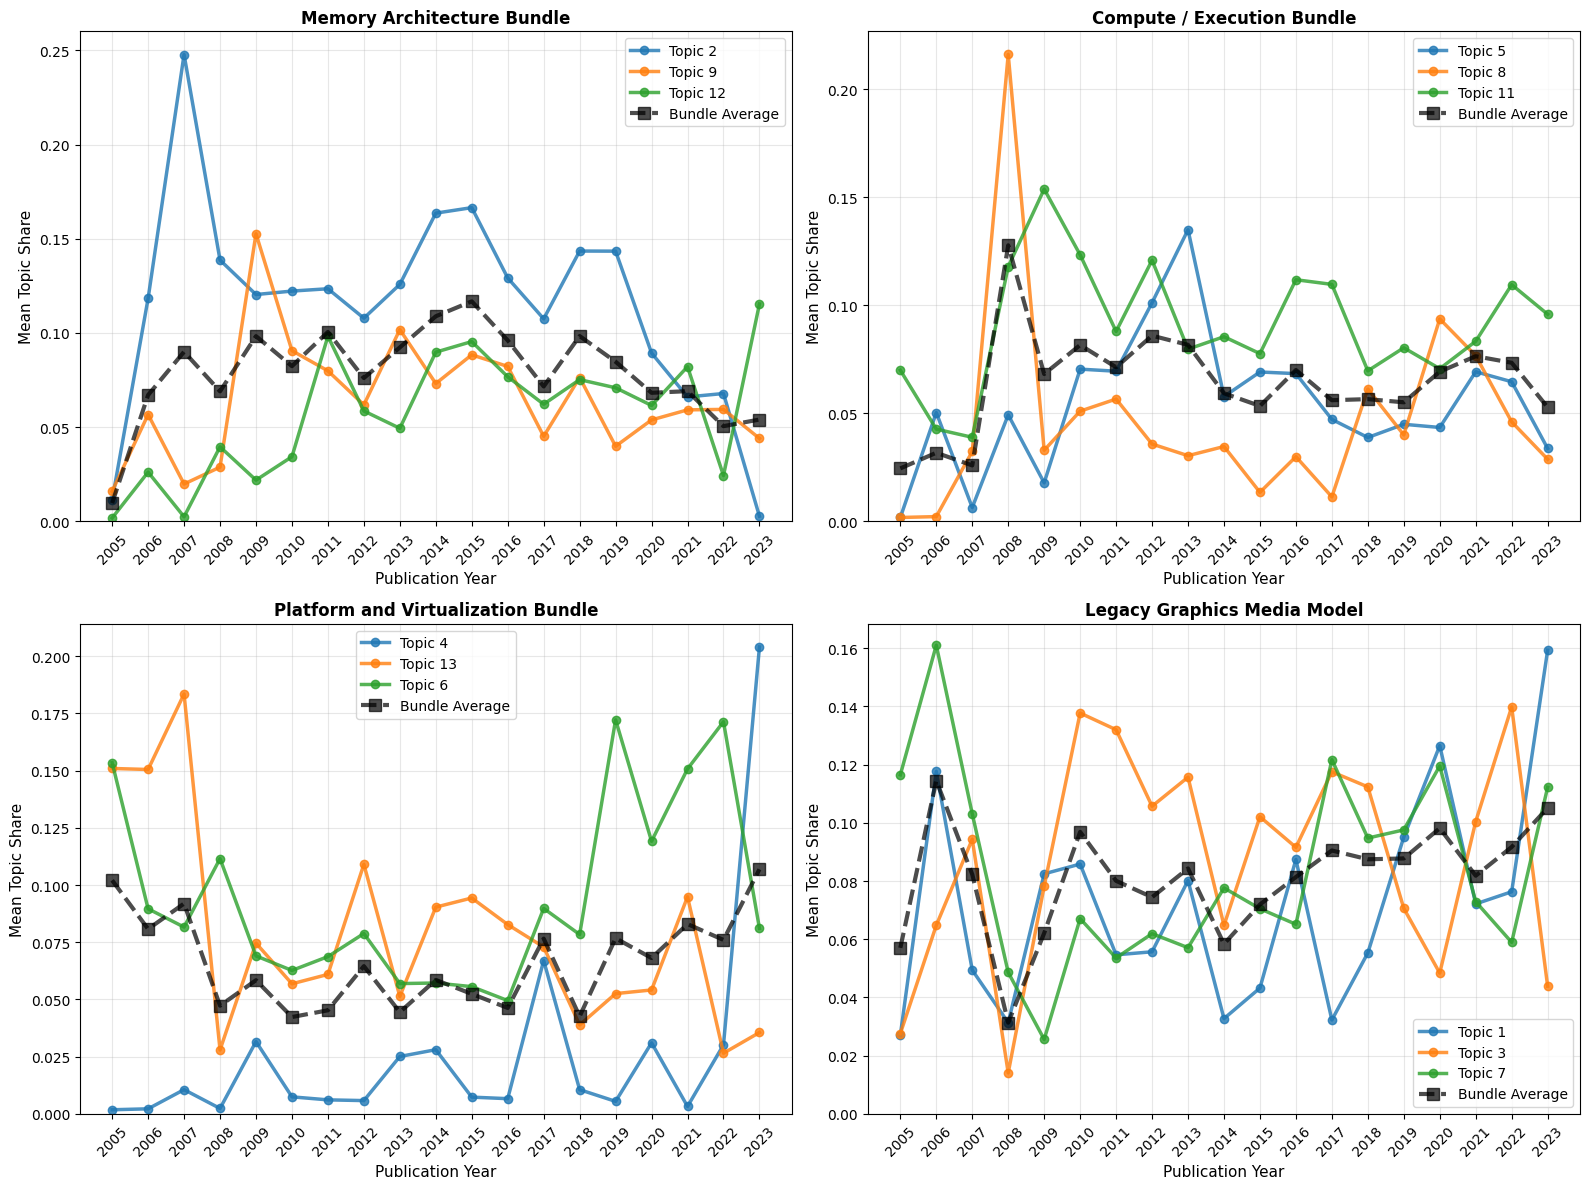


TOPIC BUNDLE TREND ANALYSIS (2005-2023)

MEMORY ARCHITECTURE BUNDLE:
  Topic 2: decreasing over time (r=-0.063)
  Topic 9: decreasing over time (r=-0.038)
  Topic 12: increasing over time (r=0.073)
  Bundle Average: decreasing over time (r=-0.033)
  → Strongest individual trend: Topic 12 (increasing, r=0.073)

COMPUTE / EXECUTION BUNDLE:
  Topic 5: decreasing over time (r=-0.009)
  Topic 8: decreasing over time (r=-0.016)
  Topic 11: decreasing over time (r=-0.029)
  Bundle Average: decreasing over time (r=-0.035)
  → Strongest individual trend: Topic 11 (decreasing, r=-0.029)

PLATFORM AND VIRTUALIZATION BUNDLE:
  Topic 4: increasing over time (r=0.082)
  Topic 13: decreasing over time (r=-0.074)
  Topic 6: increasing over time (r=0.097)
  Bundle Average: increasing over time (r=0.058)
  → Strongest individual trend: Topic 6 (increasing, r=0.097)

LEGACY GRAPHICS MEDIA MODEL:
  Topic 1: increasing over time (r=0.079)
  Topic 3: increasing over time (r=0.012)
  Topic 7: increasing ove

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')

# Filter data to 2005-2023
df_filtered = df[(df['Publication Year'] >= 2005) & (df['Publication Year'] <= 2023)].copy()

print(f"Filtering to 2005-2023: {len(df_filtered)} patents (from {len(df)} total)")

# Group by publication year and calculate mean topic probabilities
topic_cols = [f"topic_{i}" for i in range(n_topics)]
yearly_topic_means = df_filtered.groupby('Publication Year')[topic_cols].mean()

# Define topic bundles
topic_bundles = {
    'Memory Architecture Bundle': [2, 9, 12],
    'Compute / Execution Bundle': [5, 8, 11],
    'Platform and Virtualization Bundle': [4, 13, 6],
    'Legacy Graphics Media Model': [1, 3, 7]
}

# Create subplots - 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, orange, green for the 3 topics per bundle

for idx, (bundle_name, topics) in enumerate(topic_bundles.items()):
    ax = axes[idx]
    
    # Plot each topic in the bundle
    for i, topic_id in enumerate(topics):
        ax.plot(yearly_topic_means.index, yearly_topic_means[f'topic_{topic_id}'], 
                marker='o', linewidth=2.5, markersize=6, 
                label=f'Topic {topic_id}', color=colors[i], alpha=0.8)
    
    # Calculate and plot the average of the 3 topics in this bundle
    bundle_topic_cols = [f'topic_{topic_id}' for topic_id in topics]
    bundle_average = yearly_topic_means[bundle_topic_cols].mean(axis=1)
    
    ax.plot(yearly_topic_means.index, bundle_average, 
            marker='s', linewidth=3, markersize=8, 
            label='Bundle Average', color='black', alpha=0.7, linestyle='--')
    
    ax.set_xlabel('Publication Year', fontsize=11)
    ax.set_ylabel('Mean Topic Share', fontsize=11)
    ax.set_title(bundle_name, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_ylim(0, None)
    
    # Format x-axis
    ax.set_xticks(yearly_topic_means.index)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print bundle-specific trend analysis including bundle averages
print("\n" + "="*70)
print("TOPIC BUNDLE TREND ANALYSIS (2005-2023)")
print("="*70)

for bundle_name, topics in topic_bundles.items():
    print(f"\n{bundle_name.upper()}:")
    bundle_trends = []
    
    # Individual topic trends
    for topic_id in topics:
        correlation = df_filtered['Publication Year'].corr(df_filtered[f'topic_{topic_id}'])
        trend_direction = "increasing" if correlation > 0 else "decreasing"
        bundle_trends.append((topic_id, correlation, trend_direction))
        print(f"  Topic {topic_id}: {trend_direction} over time (r={correlation:.3f})")
    
    # Bundle average trend
    bundle_topic_cols = [f'topic_{topic_id}' for topic_id in topics]
    bundle_avg_series = df_filtered[bundle_topic_cols].mean(axis=1)
    bundle_correlation = df_filtered['Publication Year'].corr(bundle_avg_series)
    bundle_trend_direction = "increasing" if bundle_correlation > 0 else "decreasing"
    
    print(f"  Bundle Average: {bundle_trend_direction} over time (r={bundle_correlation:.3f})")
    
    # Find strongest individual trend in bundle
    strongest = max(bundle_trends, key=lambda x: abs(x[1]))
    print(f"  → Strongest individual trend: Topic {strongest[0]} ({strongest[2]}, r={strongest[1]:.3f})")

# Overall summary statistics
print(f"\n" + "="*70)
print("DATASET SUMMARY")
print("="*70)
print(f"Publication years: {df_filtered['Publication Year'].min()} - {df_filtered['Publication Year'].max()}")
print(f"Total patents analyzed: {len(df_filtered)}")

year_counts = df_filtered['Publication Year'].value_counts().sort_index()
print(f"Patents per year: {year_counts.min()} - {year_counts.max()} (avg: {year_counts.mean():.1f})")

print(f"\n🎯 BUNDLE ANALYSIS COMPLETE")
print(f"✅ 4 thematic topic bundles visualized (2005-2023)")
print(f"✅ Individual topics + bundle averages shown")
print(f"✅ Temporal trends identified for each bundle")
print(f"📈 Ready for thesis framework integration")

## Top Patent Owners: Topic Composition Evolution

Analyze how the largest patent holders' research focus has shifted across topic areas over time.

Patent Counts for Target Companies (2005-2023):
  NVIDIA: 122 patents
  AMD: 73 patents
  Intel: 106 patents
  Qualcomm: 107 patents
  Samsung: 48 patents
  Hyperscalers: 134 patents


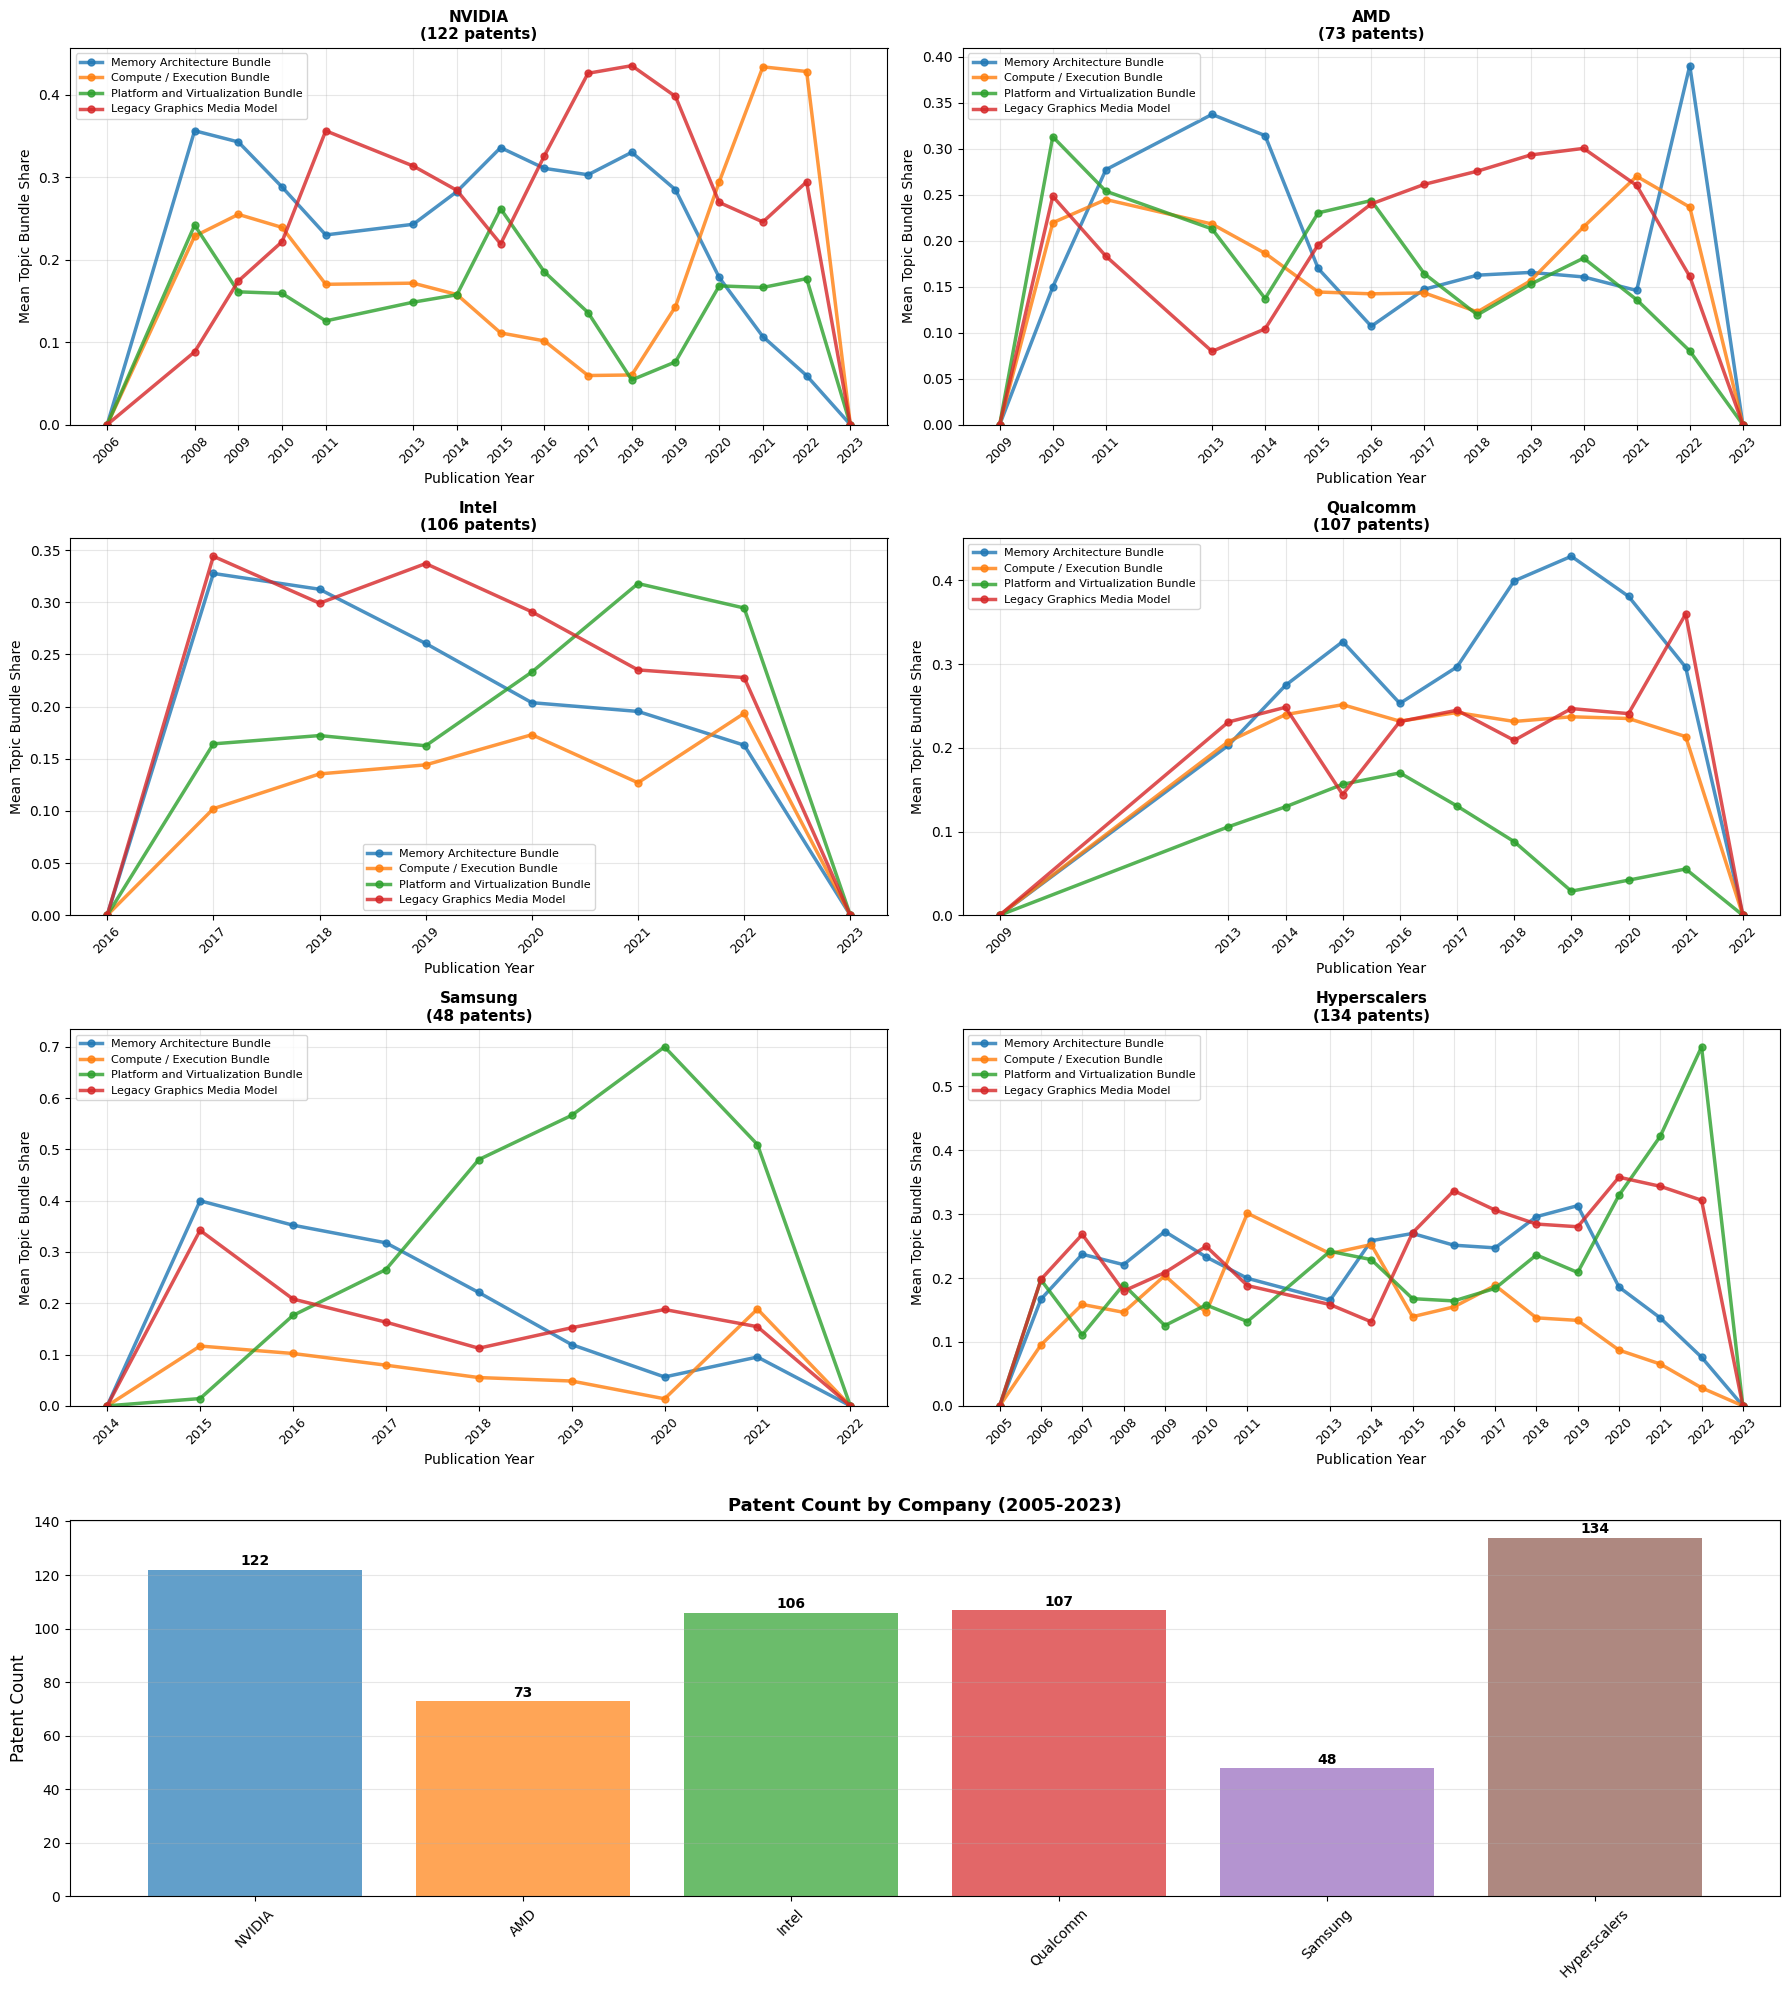


COMPANY-SPECIFIC TOPIC EVOLUTION ANALYSIS

NVIDIA (122 patents):
  Memory Architecture Bundle: decreasing (r=-0.250)
  Compute / Execution Bundle: increasing (r=0.194)
  Platform and Virtualization Bundle: decreasing (r=-0.093)
  Legacy Graphics Media Model: increasing (r=0.187)
  Publication range: 2005-2023
  Dominant focus: Memory Architecture Bundle (avg share: 0.092)

AMD (73 patents):
  Memory Architecture Bundle: increasing (r=0.032)
  Compute / Execution Bundle: increasing (r=0.069)
  Platform and Virtualization Bundle: decreasing (r=-0.195)
  Legacy Graphics Media Model: increasing (r=0.072)
  Publication range: 2009-2023
  Dominant focus: Legacy Graphics Media Model (avg share: 0.074)

INTEL (106 patents):
  Memory Architecture Bundle: decreasing (r=-0.180)
  Compute / Execution Bundle: increasing (r=0.097)
  Platform and Virtualization Bundle: increasing (r=0.151)
  Legacy Graphics Media Model: decreasing (r=-0.119)
  Publication range: 2007-2023
  Dominant focus: Legacy Gr

In [45]:
# Analyze specific patent owners and their topic evolution over time
import matplotlib.pyplot as plt

# Clean and standardize owner names
df_owner = df_filtered.copy()
df_owner['Clean_Owner'] = df_owner['Applicants'].str.split(';').str[0].str.strip()

# Define specific companies to analyze
target_companies = {
    'NVIDIA': ['NVIDIA', 'Nvidia', 'nvidia'],
    'AMD': ['AMD', 'Advanced Micro Devices', 'ADVANCED MICRO DEVICES'],
    'Intel': ['Intel', 'INTEL'],
    'Qualcomm': ['Qualcomm', 'QUALCOMM'],
    'Samsung': ['Samsung', 'SAMSUNG'],
    'Hyperscalers': ['Google', 'Amazon', 'Microsoft', 'GOOGLE', 'AMAZON', 'MICROSOFT', 'Alphabet']
}

# Function to map owner to target company
def map_to_target_company(owner_name):
    if pd.isna(owner_name):
        return None
    for target, variants in target_companies.items():
        for variant in variants:
            if variant in owner_name:
                return target
    return None

# Map owners to target companies
df_owner['Target_Company'] = df_owner['Clean_Owner'].apply(map_to_target_company)

# Get patent counts for target companies
target_patent_counts = df_owner['Target_Company'].value_counts()
print("Patent Counts for Target Companies (2005-2023):")
for company in ['NVIDIA', 'AMD', 'Intel', 'Qualcomm', 'Samsung', 'Hyperscalers']:
    count = target_patent_counts.get(company, 0)
    print(f"  {company}: {count} patents")

# Create figure with subplots - 3 rows, 2 columns for topic evolution + 1 row for patent counts
fig = plt.figure(figsize=(18, 20))

# Use the same topic bundles as before
topic_bundles = {
    'Memory Architecture Bundle': [2, 9, 12],
    'Compute / Execution Bundle': [5, 8, 11],
    'Platform and Virtualization Bundle': [4, 13, 6],
    'Legacy Graphics Media Model': [1, 3, 7]
}

# Define colors for the 4 bundles
bundle_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot topic evolution for each target company (6 subplots in 3x2 grid)
for idx, company in enumerate(['NVIDIA', 'AMD', 'Intel', 'Qualcomm', 'Samsung', 'Hyperscalers']):
    ax = plt.subplot(4, 2, idx + 1)
    
    # Filter data for this company
    company_data = df_owner[df_owner['Target_Company'] == company]
    patent_count = len(company_data)
    
    if len(company_data) > 0:
        # Group by year and calculate mean topic shares for this company
        company_counts_by_year = company_data.groupby('Publication Year').size()
        valid_years = company_counts_by_year[company_counts_by_year >= 2].index  # tune threshold
        company_yearly_means = (
            company_data[company_data['Publication Year'].isin(valid_years)]
            .groupby('Publication Year')[topic_cols]
            .mean()
            .sort_index()
        )

        company_yearly_means = company_yearly_means.rolling(window=3, center=True).mean()
        
        # Plot each bundle average for this company
        for bundle_idx, (bundle_name, topics) in enumerate(topic_bundles.items()):
            bundle_topic_cols = [f'topic_{topic_id}' for topic_id in topics]
            bundle_average = company_yearly_means[bundle_topic_cols].sum(axis=1)
            
            ax.plot(company_yearly_means.index, bundle_average, 
                    marker='o', linewidth=2.5, markersize=5, 
                    label=bundle_name, color=bundle_colors[bundle_idx], alpha=0.8)
        
        ax.set_xlabel('Publication Year', fontsize=10)
        ax.set_ylabel('Mean Topic Bundle Share', fontsize=10)
        ax.set_title(f'{company}\n({patent_count} patents)', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        ax.set_ylim(0, None)
        
        # Format x-axis
        if len(company_yearly_means.index) > 0:
            ax.set_xticks(company_yearly_means.index)
            ax.tick_params(axis='x', rotation=45, labelsize=9)
    else:
        ax.text(0.5, 0.5, f'{company}\nNo patents found', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{company}\n(0 patents)', fontsize=11, fontweight='bold')

# Add patent count comparison chart
ax_counts = plt.subplot(4, 2, (7, 8))
companies_with_data = [comp for comp in ['NVIDIA', 'AMD', 'Intel', 'Qualcomm', 'Samsung', 'Hyperscalers'] 
                      if target_patent_counts.get(comp, 0) > 0]
patent_counts_data = [target_patent_counts.get(comp, 0) for comp in companies_with_data]

bars = ax_counts.bar(companies_with_data, patent_counts_data, 
                    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'][:len(companies_with_data)],
                    alpha=0.7)

# Add patent count labels on bars
for bar, count in zip(bars, patent_counts_data):
    height = bar.get_height()
    ax_counts.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{int(count)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax_counts.set_ylabel('Patent Count', fontsize=12)
ax_counts.set_title('Patent Count by Company (2005-2023)', fontsize=13, fontweight='bold')
ax_counts.tick_params(axis='x', rotation=45)
ax_counts.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print detailed analysis for each target company
print("\n" + "="*80)
print("COMPANY-SPECIFIC TOPIC EVOLUTION ANALYSIS")
print("="*80)

for company in ['NVIDIA', 'AMD', 'Intel', 'Qualcomm', 'Samsung', 'Hyperscalers']:
    company_data = df_owner[df_owner['Target_Company'] == company]
    patent_count = len(company_data)
    
    print(f"\n{company.upper()} ({patent_count} patents):")
    
    if patent_count == 0:
        print("  No patents found in dataset")
        continue
    
    # Calculate bundle trends for this company
    for bundle_name, topics in topic_bundles.items():
        bundle_topic_cols = [f'topic_{topic_id}' for topic_id in topics]
        
        # Only calculate trends if company has multiple years of data
        if len(company_data['Publication Year'].unique()) > 1:
            company_bundle_avg = company_data[bundle_topic_cols].mean(axis=1)
            correlation = company_data['Publication Year'].corr(company_bundle_avg)
            trend_direction = "increasing" if correlation > 0 else "decreasing"
            
            print(f"  {bundle_name}: {trend_direction} (r={correlation:.3f})")
        else:
            print(f"  {bundle_name}: insufficient temporal data")
    
    # Show publication year range for this company
    if patent_count > 0:
        year_range = f"{company_data['Publication Year'].min()}-{company_data['Publication Year'].max()}"
        print(f"  Publication range: {year_range}")
        
        # Show dominant topic bundle for this company
        company_bundle_means = {}
        for bundle_name, topics in topic_bundles.items():
            bundle_topic_cols = [f'topic_{topic_id}' for topic_id in topics]
            company_bundle_means[bundle_name] = company_data[bundle_topic_cols].mean().mean()
        
        dominant_bundle = max(company_bundle_means.items(), key=lambda x: x[1])
        print(f"  Dominant focus: {dominant_bundle[0]} (avg share: {dominant_bundle[1]:.3f})")

print(f"\n🎯 COMPANY ANALYSIS COMPLETE")
print(f"✅ 6 key GPU companies/groups analyzed")
print(f"✅ Topic bundle evolution tracked per company")
print(f"✅ Patent count comparison visualized")
print(f"✅ Corporate innovation strategies revealed")
print(f"📈 Ready for competitive analysis framework")